# Tuning du modèle

L'objet de ce notebook est d'illustrer les différentes étapes de tuning du modèle.


## Préambule

### Imports

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [56]:
# imports and customization of diplay
# import os
import re
from functools import partial
from itertools import product
# import numpy as np
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
import matplotlib.ticker as mtick
import seaborn as sns

from src.pimest import ContentGetter
from src.pimest import PathGetter
from src.pimest import PDFContentParser
from src.pimest import BlockSplitter
from src.pimest import SimilaritySelector
from src.pimest import custom_accuracy
from src.pimest import text_sim_score
# from src.pimest import text_similarity
# from src.pimest import build_text_processor

### Acquisition des données

On récupère les données manuellement étiquetées et on les intègre dans un dataframe

In [3]:
ground_truth_df = pd.read_csv(Path('..') / '..' / 'ground_truth' / 'manually_labelled_ground_truth.csv',
                              sep=';',
                              encoding='latin-1',
                              index_col='uid')
ground_truth_uids = list(ground_truth_df.index)

acqui_pipe = Pipeline([('PathGetter', PathGetter(ground_truth_uids=ground_truth_uids,
                                                  train_set_path=Path('..') / '..' / 'ground_truth',
                                                  ground_truth_path=Path('..') / '..' / 'ground_truth',
                                                  )),
                        ('ContentGetter', ContentGetter(missing_file='to_nan')),
                        ('ContentParser', PDFContentParser(none_content='to_empty')),
                       ],
                       verbose=True)

texts_df = acqui_pipe.fit_transform(ground_truth_df)
texts_df['ingredients'] = texts_df['ingredients'].fillna('')
texts_df

[Pipeline] ........ (step 1 of 3) Processing PathGetter, total=   0.1s
[Pipeline] ..... (step 2 of 3) Processing ContentGetter, total=   0.1s
Launching 8 processes.
[Pipeline] ..... (step 3 of 3) Processing ContentParser, total=  37.8s


,designation,ingredients,path,content,text
uid,,,,,
a0492df6-9c76-4303-8813-65ec5ccbfa70,Concentré liquide Asian en bouteille 980 ml CHEF,"Eau, maltodextrine, sel, arômes, sucre, arôme ...",../../ground_truth/a0492df6-9c76-4303-8813-65e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,Concentré Liquide Asian CHEF® \n\nBouteille de...
d183e914-db2f-4e2f-863a-a3b2d054c0b8,Pain burger curry 80 g CREATIV BURGER,"Farine de blé T65, eau, levure, vinaigre de ci...",../../ground_truth/d183e914-db2f-4e2f-863a-a3b...,b'%PDF-1.5\r%\xe2\xe3\xcf\xd3\r\n4 0 obj\r<</L...,
ab48a1ed-7a3d-4686-bb6d-ab4f367cada8,Macaroni en sachet 500 g PANZANI,- 100% Semoule de BLE dur de qualité supérieur...,../../ground_truth/ab48a1ed-7a3d-4686-bb6d-ab4...,b'%PDF-1.4\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,Direction Qualité \n\n \n\n \n\nPATES ALIMENTA...
...,...,...,...,...,...
e67341d8-350f-46f4-9154-4dbbb8035621,PRÉPARATION POUR CRÈME BRÛLÉE BIO 6L,"Sucre roux de canne*° (64%), amidon de maïs*, ...",../../ground_truth/e67341d8-350f-46f4-9154-4db...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,FICHE TECHNIQUE \n\nCREME BRÛLÉE 6L \n\nREF : ...
a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3,Céréales instantanées en poudre saveur caramel...,"Farine 87,1 % (Blé (GLUTEN), Blé hydrolysé (GL...",../../ground_truth/a8f6f672-20ac-4ff8-a8f2-3bc...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,81 rue de Sans Souci – CS13754 – 69576 Limones...
0faad739-ea8c-4f03-b62e-51ee592a0546,"FARINE DE BLÉ TYPE 45, 10KG",Farine de blé T45,../../ground_truth/0faad739-ea8c-4f03-b62e-51e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,\n1050/10502066400 \n\n10502055300/1050202520...


### Train / Test split

On va appliquer une grid search pour déterminer les meilleurs paramètres de notre modèle. 
Pour ne pas surestimer la performance du modèle, il est nécessaire de bien séparer le jeu de test du jeu d'entraînement, y compris pour la grid search !

In [4]:
train, test = train_test_split(texts_df, test_size=100, random_state=42)

Dans toute la suite, on utilisera le jeu d'entraînement pour effectuer le tuning des hyperparamètres.

## Ajustement de la fonction de découpage des textes

L'objectif de cette partie est d'optimiser la fonction de découpage des textes en blocs. On va tester quelques fonctions candidates, via une GridSearch.

### Définition des fonctions candidates

On définit les fonctions de split : 

In [5]:
# definitions of splitter funcs
splitter_funcs = []
def split_func1(text):
    return(text.split('\n\n'))
splitter_funcs.append(split_func1)
def split_func2(text):
    return(text.split('\n'))
splitter_funcs.append(split_func2)
def split_func3(text):
    regex = r'\s*\n\s*\n\s*'
    return(re.split(regex, text))
splitter_funcs.append(split_func3)

### Mise en place du pipeline

On construit ensuite un pipeline de traitement du texte.
Le SimilaritySelector prenant en entrée une pandas.Series, on définit entre le BlockSplitter (dont la méthode transform() retourne un pandas.DataFrame) et le SimilaritySelector une fonction utilitaire qui séléctionne la colonne 'blocks'.

In [6]:
def select_col(df, col_name='blocks'):
        return(df[col_name].fillna(''))
col_selector = FunctionTransformer(select_col)    

In [7]:
process_pipe = Pipeline([('Splitter', BlockSplitter()),
                         ('ColumnSelector', col_selector),
                         ('SimilaritySelector', SimilaritySelector())
                        ],
                       verbose=False)

On peut tester le fonctionnement de ce Pipeline.
Attention, les résultats ne sont pas représentatifs, on entraîne et on prédit sur le même jeu de données !

In [8]:
process_pipe.fit(train, train['ingredients'])
process_pipe.predict(train)

Launching 8 processes.
Launching 8 processes.


uid
02d5ceb9-21c2-4965-8f65-309bca7638b2    Café chicorée solubles et fibres de chicorée.\...
bbe72396-6ed4-4df1-935b-0c0a7dbd77dc                                                     
507b428e-e99d-464b-b9d3-50629efe4355    COMPOSITION\nMélange de Blés de pays recommand...
                                                              ...                        
4b28bb17-1f1d-4cbb-ac3b-80227ef248ab    Gluten\nCrustacés\nOeufs\nPoisson\nSoja\nLait\...
d2137dae-ff21-46ec-83be-7400773c6c3b    Amidon modifié de pomme de terre - Fécule de p...
571d98ae-9647-4bd4-ad1a-a497f93987cb    Composition typique (Données inappropriées pou...
Length: 400, dtype: object

### Helper fonction

On doit faire varier dans la grid search des paramètres qui sont packés sous forme de dictionnaires avant d'être passés au SimilaritySelector.
On construit une fonction qui permet de construire le produit cartésien qui va bien pour ces paramètres.

In [9]:
def prod_params(dict_to_prod):
    """ 
    In : dict of dicts.
    First level key : parameter name
    Second level key : name of scenario with this parameter value
    Values : parameter value
    
    Returns a tuple: 
        - list of labels to name scenario
        - list of dictionaries to pass to count_vect_kwargs
    """
    label_lists = [list(dict_.keys()) for dict_ in dict_to_prod.values()]
    labels = list(map(lambda x: ', '.join(x), list(product(*label_lists))))
    values_iter = list(product(*[list(dict_.values()) for dict_ in dict_to_prod.values()]))
    parms_names = list(dict_to_prod.keys())
    dict_out = [{key: val for (key, val) in zip(parms_names, values_)} for values_ in values_iter]
    return(labels, dict_out)

In [10]:
prod_params({'stop_words': {'no stopwords removal': None, 'with stopwords removal' : {'de', 'le'}},
             'ngram_ranges': {'no_ngram': (1, 1), 'bigrams': (1, 2)}})

(['no stopwords removal, no_ngram',
  'no stopwords removal, bigrams',
  'with stopwords removal, no_ngram',
  'with stopwords removal, bigrams'],
 [{'stop_words': None, 'ngram_ranges': (1, 1)},
  {'stop_words': None, 'ngram_ranges': (1, 2)},
  {'stop_words': {'de', 'le'}, 'ngram_ranges': (1, 1)},
  {'stop_words': {'de', 'le'}, 'ngram_ranges': (1, 2)}])

### Stockage des résultats dans un dataframe

Au fil des lancements des grid search, on stockera les données dans un dataframe afin de pouvoir les analyser plus simplement après coup.

In [11]:
result_df = pd.DataFrame()
result_df

""


### Application de la GridSearch : tuning du text preprocessing (run 1)

On applique ensuite une grid search en faisant varier les fonctions de text preprocessing : 
- fonction de split du texte des documents en blocs
- retrait ou non de stopwords
- prise en compte de ngrams
- juste pour une première comparaison, choix du candidat par projection l1/l2 ou par similarité cosinus

On scorera via la similarité de Levenshtein.

In [12]:
lev_scorer = partial(text_sim_score, similarity='levenshtein')

In [13]:
stop_words = {'pas', 'le', 'en', 'pour', 'ou', 'ce', 'de', 'dans', 'du', 'and', 'un', 'sur', 'et',
              'of', 'est', 'par', 'la', 'les', 'dont', 'au', 'des', 'que'}

In [14]:
ngram_ranges = {'no_ngram': (1, 1), 'bigrams': (1, 2), 'trigrams': (1, 3)}

In [15]:
kwargs_to_prod = prod_params({'stop_words': {'no stopwords removal': None, 'with stopwords removal' : stop_words},
                              'ngram_range': ngram_ranges,
                              'strip_accents': {'keep accents': None, 'remove accents': 'unicode'}
                             }
                            )

In [16]:
param_grid = [{'Splitter__splitter_func': splitter_funcs,
               'SimilaritySelector__similarity': ['projection', 'cosine'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              }
             ]
search = GridSearchCV(process_pipe,
                      param_grid,
                      cv=8, 
                      scoring= ({'similarity': lev_scorer, 'accuracy': custom_accuracy}),
                      refit='similarity',
                      n_jobs=-1,
                      verbose=1,
                     ).fit(train, train['ingredients'])

Fitting 8 folds for each of 72 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min


Launching 8 processes.


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  3.9min finished


In [17]:
labels = list(product(kwargs_to_prod[0], ['Projection l2/l1', 'Cosinus'], ['Split 1', 'Split 2', 'Split 3']))
labels = list(map(lambda x: ', '.join(x), labels))

In [18]:
for i in range(len(search.cv_results_['rank_test_similarity'])):
    str_result = f"{search.cv_results_['mean_test_similarity'][i]:.2%} +/- {search.cv_results_['std_test_similarity'][i]:.2%}"
    print(labels[i], str_result)

no stopwords removal, no_ngram, keep accents, Projection l2/l1, Split 1 50.15% +/- 5.61%
no stopwords removal, no_ngram, keep accents, Projection l2/l1, Split 2 38.90% +/- 4.52%
no stopwords removal, no_ngram, keep accents, Projection l2/l1, Split 3 52.65% +/- 6.09%
no stopwords removal, no_ngram, keep accents, Cosinus, Split 1 40.30% +/- 4.91%
no stopwords removal, no_ngram, keep accents, Cosinus, Split 2 25.87% +/- 2.25%
no stopwords removal, no_ngram, keep accents, Cosinus, Split 3 41.98% +/- 5.27%
no stopwords removal, no_ngram, remove accents, Projection l2/l1, Split 1 49.47% +/- 5.77%
no stopwords removal, no_ngram, remove accents, Projection l2/l1, Split 2 38.56% +/- 4.19%
no stopwords removal, no_ngram, remove accents, Projection l2/l1, Split 3 52.02% +/- 6.05%
no stopwords removal, no_ngram, remove accents, Cosinus, Split 1 40.93% +/- 5.02%
no stopwords removal, no_ngram, remove accents, Cosinus, Split 2 26.06% +/- 2.00%
no stopwords removal, no_ngram, remove accents, Cosinus,

On tire de ce premier test:
- que le modèle est bien plus performant avec le retrait des stopwords
- que le split le plus efficace est la fonction qui applique la regex (deux retours chariots parmi des whitespaces) - split 3
- que la prise en compte de bigrammes améliore, avec les trigrammes en plus on ne gagne rien
- que la similarité cosinus semble sensiblement moins performante que le choix par projection (l2/l1)

Remarque : la standard dev est quand même assez élevée (de l'ordre de 5-6%). Les scénarios avec peu d'écart entre leurs moyennes (2-3%) ne sont pas départageables via cette grid search.

On sauvegarde les résultat dans le dataframe qu'on analysera à la fin

In [19]:
result_df = pd.DataFrame(search.cv_results_)
result_df['run'] = 1

### Application de la Grid Search : tuning du calcul de similarité (run 2)

On va maintenant déterminer, sur la base des paramètres déjà retenus, le mode de calcul de similarité le plus performant.
Seul le calcul par projection est paramétrique (norme dans l'espace de départ vs. norme sur l'espace projeté), on fera uniquement varier ces paramètres (en plus de la comparaison avec la similarité cosinus).

On comparera également la performance du modèle selon qu'on vectorise les textes via les comptes de mots, ou bien seulement via un identifiant binaire (présence ou absence du mot).

In [20]:
process_pipe.set_params(**{'Splitter__splitter_func': splitter_funcs[2],
                           })

kwargs_to_prod = prod_params({'stop_words': {'with stopwords removal' : stop_words},
                              'ngram_range': {'bigrams': (1, 2)},
                              'binary': {'counts': False, 'binary flag': True},
                              'strip_accents': {'remove accents': 'unicode'}
                             })

param_grid = [{
               'SimilaritySelector__source_norm': ['l1'],
               'SimilaritySelector__projected_norm': ['l1'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l2'],
               'SimilaritySelector__projected_norm': ['l2'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l2'],
               'SimilaritySelector__projected_norm': ['l1'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },    
              {
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l3'],
               'SimilaritySelector__projected_norm': ['l2'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l4'],
               'SimilaritySelector__projected_norm': ['l3'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l5'],
               'SimilaritySelector__projected_norm': ['l4'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l6'],
               'SimilaritySelector__projected_norm': ['l5'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l3'],
               'SimilaritySelector__projected_norm': ['l1'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l4'],
               'SimilaritySelector__projected_norm': ['l2'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l5'],
               'SimilaritySelector__projected_norm': ['l3'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l6'],
               'SimilaritySelector__projected_norm': ['l4'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l7'],
               'SimilaritySelector__projected_norm': ['l5'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l4'],
               'SimilaritySelector__projected_norm': ['l1'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l5'],
               'SimilaritySelector__projected_norm': ['l2'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l6'],
               'SimilaritySelector__projected_norm': ['l3'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l7'],
               'SimilaritySelector__projected_norm': ['l4'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__source_norm': ['l8'],
               'SimilaritySelector__projected_norm': ['l5'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              },
              {
               'SimilaritySelector__similarity': ['cosine'],
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
              }
             ]
search = GridSearchCV(process_pipe,
                      param_grid,
                      cv=8, 
                      scoring= ({'similarity': lev_scorer, 'accuracy': custom_accuracy}),
                      refit='similarity',
                      n_jobs=-1,
                      verbose=1,
                     ).fit(train, train['ingredients'])

Fitting 8 folds for each of 36 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min


Launching 8 processes.


[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.9min finished


In [21]:
labels = ['l1, l1',
          'l2, l2', 
          'l2, l1',
          'l3, l2',
          'l4, l3',
          'l5, l4',
          'l6, l5',
          'l3, l1',          
          'l4, l2',
          'l5, l3',
          'l6, l4',  
          'l7, l5',         
          'l4, l1',
          'l5, l2',
          'l6, l3',
          'l7, l4',  
          'l8, l5',             
          'cosine',
         ]

labels = list(product(labels, kwargs_to_prod[0]))
labels = list(map(lambda x: ', '.join(x), labels))

for i in range(len(search.cv_results_['rank_test_similarity'])):
    str_result = f"{search.cv_results_['mean_test_similarity'][i]:.2%} +/- {search.cv_results_['std_test_similarity'][i]:.2%}"
    print(labels[i], str_result)

l1, l1, with stopwords removal, bigrams, counts, remove accents 17.87% +/- 2.52%
l1, l1, with stopwords removal, bigrams, binary flag, remove accents 17.90% +/- 2.55%
l2, l2, with stopwords removal, bigrams, counts, remove accents 17.87% +/- 2.52%
l2, l2, with stopwords removal, bigrams, binary flag, remove accents 17.90% +/- 2.55%
l2, l1, with stopwords removal, bigrams, counts, remove accents 60.86% +/- 5.65%
l2, l1, with stopwords removal, bigrams, binary flag, remove accents 61.00% +/- 5.61%
l3, l2, with stopwords removal, bigrams, counts, remove accents 61.55% +/- 5.25%
l3, l2, with stopwords removal, bigrams, binary flag, remove accents 62.05% +/- 4.73%
l4, l3, with stopwords removal, bigrams, counts, remove accents 59.61% +/- 4.00%
l4, l3, with stopwords removal, bigrams, binary flag, remove accents 62.61% +/- 4.29%
l5, l4, with stopwords removal, bigrams, counts, remove accents 56.23% +/- 3.40%
l5, l4, with stopwords removal, bigrams, binary flag, remove accents 61.82% +/- 3.67

On tire de ce second test les conclusions suivantes :
- comme lors du premier test, l'identification du meilleur candidat par similarité cosinus est moins performante que par projection
- plusieurs configurations de paramètres permettent d'obtenir des performance similaires via la projection : 
    - l2/l1
    - l2/l1b
    - l3/l2
    - l3/l2b
    - l3/l1b
    - l4/l2
    - l4/l2b

In [22]:
result_df = result_df.loc[result_df['run'] != 2.]
result_df = pd.concat([result_df, pd.DataFrame(search.cv_results_)], axis=0, ignore_index=True)
result_df['run'] = result_df['run'].fillna(2)
len(result_df)

108

### Application de la Grid Search : impact des mots non vus en entrainement (run 3)

On va également voir si l'utilisation d'un vectorizer de type HashingVectorizer, qui permet de prendre en compte des mots non vus lors de l'entraînement a un impact sur la performance (ou son écart type, qui est très élevé...).

In [23]:
process_pipe.set_params(**{'Splitter__splitter_func': splitter_funcs[2],

                           })

kwargs_to_prod = prod_params({'stop_words': {'with stopwords removal' : stop_words},
                              'ngram_range': {'bigrams': (1, 2)},
                              'binary': {'counts': False, 'binary flag': True},
                             })

param_grid = [{'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__count_vect_type': ['TfidfVectorizer', 'HashingVectorizer'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l4'],
               'SimilaritySelector__projected_norm': ['l2'],               
              },
              {'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__count_vect_type': ['TfidfVectorizer', 'HashingVectorizer'],
               'SimilaritySelector__similarity': ['projection'],               
               'SimilaritySelector__source_norm': ['l3'],
               'SimilaritySelector__projected_norm': ['l2'],
              },
              {'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__count_vect_type': ['TfidfVectorizer', 'HashingVectorizer'],
               'SimilaritySelector__similarity': ['projection'],               
               'SimilaritySelector__source_norm': ['l2'],
               'SimilaritySelector__projected_norm': ['l1'],
              },
              {'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__count_vect_type': ['TfidfVectorizer', 'HashingVectorizer'],
               'SimilaritySelector__similarity': ['cosine'],               
              },
             ]
search = GridSearchCV(process_pipe,
                      param_grid,
                      cv=8, 
                      scoring= ({'similarity': lev_scorer, 'accuracy': custom_accuracy}),
                      refit='similarity',
                      n_jobs=-1,
                      verbose=1,
                     ).fit(train, train['ingredients'])

Fitting 8 folds for each of 16 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s


Launching 8 processes.


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   54.2s finished


In [24]:
labels = [
          'l4/l2',
          'l3/l2',
          'l2/l1',
          'cosine'
         ]

labels = list(product(labels, kwargs_to_prod[0], ['TfidfVectorizer', 'HashingVectorizer']))
labels = list(map(lambda x: ', '.join(x), labels))

for i in range(len(search.cv_results_['rank_test_similarity'])):
    str_result = f"{search.cv_results_['mean_test_similarity'][i]:.2%} +/- {search.cv_results_['std_test_similarity'][i]:.2%}"
    print(labels[i], str_result)

l4/l2, with stopwords removal, bigrams, counts, TfidfVectorizer 61.11% +/- 5.30%
l4/l2, with stopwords removal, bigrams, counts, HashingVectorizer 61.07% +/- 5.23%
l4/l2, with stopwords removal, bigrams, binary flag, TfidfVectorizer 61.00% +/- 5.61%
l4/l2, with stopwords removal, bigrams, binary flag, HashingVectorizer 60.51% +/- 5.54%
l3/l2, with stopwords removal, bigrams, counts, TfidfVectorizer 61.55% +/- 5.25%
l3/l2, with stopwords removal, bigrams, counts, HashingVectorizer 59.97% +/- 5.25%
l3/l2, with stopwords removal, bigrams, binary flag, TfidfVectorizer 62.05% +/- 4.73%
l3/l2, with stopwords removal, bigrams, binary flag, HashingVectorizer 59.58% +/- 5.46%
l2/l1, with stopwords removal, bigrams, counts, TfidfVectorizer 60.86% +/- 5.65%
l2/l1, with stopwords removal, bigrams, counts, HashingVectorizer 60.36% +/- 5.89%
l2/l1, with stopwords removal, bigrams, binary flag, TfidfVectorizer 61.00% +/- 5.61%
l2/l1, with stopwords removal, bigrams, binary flag, HashingVectorizer 60.

L'utilisation d'un HashingVectorizer à la place d'un TfidfVectorizer, pour prendre en compte les mots non vus lors de l'entrainement, n'a pas d'impact positif sur la performance du modèle.
Au contraire, elle semble globalement diminuer de quelques points.

In [25]:
result_df = pd.concat([result_df, pd.DataFrame(search.cv_results_)], axis=0, ignore_index=True)
result_df['run'] = result_df['run'].fillna(3)
len(result_df)

124

### Application d'une grid search : pondération des mots  (run 4)

On va en plus appliquer une pondération absolue et relative des mots, dans la recherche de similarité par cosinus.

Les différentes possibilités pour le vecteur cible sont : 
- moyenne des vecteurs de textes des listes d'ingrédients, avec uniquement un flag binaire (présence / absence du mot) : la cible est la document frequency moyenne des mots des listes d'ingrédients
- moyenne des vecteurs de textes des listes d'ingrédients, avec en prenant en compte les comptes des mots dans chacun des textes : la cible est la term frequency moyenne des mots au sein des listes d'ingrédients
- moyenne des scores "absolus" de chacun des mots au sein des listes d'ingrédients. Il s'agit d'une "smooth document frequency" (elle croit logarithmiquement)
- moyenne des scores "relatifs" de chacun des mots entre liste d'ingrédients et contenu des fiches techniques. Ici on compare la doc frequency entre les deux corpus, pour donner plus de poids aux mots qui sont plus présents dans les listes d'ingrédients que dans le reste du corps du texte.

On comparera à la projection l4/l2b, qui porte jusque là les meilleurs résultats.

In [26]:
process_pipe.set_params(**{'Splitter__splitter_func': splitter_funcs[2],
                           'SimilaritySelector__count_vect_type': 'TfidfVectorizer',
                           })

kwargs_to_prod = prod_params({'stop_words': {'with stopwords removal' : stop_words},
                              'ngram_range': {'no_ngrams': (1, 1), 'bigrams': (1, 2)},
                              'binary': {'counts': False, 'binary flag': True},
                              'use_idf': {'without idf': False, 'with idf': True},
                              'strip_accents': {'remove accents': 'unicode'},
                             })

param_grid = [{
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__scoring': ['default', 'absolute_score', 'relative_score'],    
               'SimilaritySelector__similarity': ['cosine'],
              },
              {'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l4'],
               'SimilaritySelector__projected_norm': ['l2'],                   
              },
             ]
search = GridSearchCV(process_pipe,
                      param_grid,
                      cv=8, 
                      scoring= ({'similarity': lev_scorer, 'accuracy': custom_accuracy}),
                      refit='similarity',
                      n_jobs=-1,
                      verbose=1,
                     ).fit(train, train['ingredients'])

Fitting 8 folds for each of 32 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min


Launching 8 processes.


[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  1.8min finished


In [27]:
labels = [
          'cosine',
         ]


labels = list(product(labels, kwargs_to_prod[0], ['default', 'absolute score', 'relative score']))
labels.extend(list(product(['projection l4/l2'],  kwargs_to_prod[0])))
labels = list(map(lambda x: ', '.join(x), labels))

for i in range(len(search.cv_results_['rank_test_similarity'])):
    str_result = f"{search.cv_results_['mean_test_similarity'][i]:.2%} +/- {search.cv_results_['std_test_similarity'][i]:.2%}"
    print(labels[i], str_result)

cosine, with stopwords removal, no_ngrams, counts, without idf, remove accents, default 53.69% +/- 7.13%
cosine, with stopwords removal, no_ngrams, counts, without idf, remove accents, absolute score 54.47% +/- 6.87%
cosine, with stopwords removal, no_ngrams, counts, without idf, remove accents, relative score 29.42% +/- 5.32%
cosine, with stopwords removal, no_ngrams, counts, with idf, remove accents, default 55.47% +/- 6.70%
cosine, with stopwords removal, no_ngrams, counts, with idf, remove accents, absolute score 52.47% +/- 6.91%
cosine, with stopwords removal, no_ngrams, counts, with idf, remove accents, relative score 32.73% +/- 5.21%
cosine, with stopwords removal, no_ngrams, binary flag, without idf, remove accents, default 53.29% +/- 7.86%
cosine, with stopwords removal, no_ngrams, binary flag, without idf, remove accents, absolute score 54.15% +/- 8.17%
cosine, with stopwords removal, no_ngrams, binary flag, without idf, remove accents, relative score 28.02% +/- 5.00%
cosine,

In [28]:
result_df = pd.concat([result_df, pd.DataFrame(search.cv_results_)], axis=0, ignore_index=True)
result_df['run'] = result_df['run'].fillna(4)
len(result_df)

156

On en déduit :
- que la similarité par projection reste le mode de détermination du candidat le plus efficace
- que dans ce mode, l'utilisation de l'idf dégrade la performance
- néanmoins, dans le cadre de la similarité cosinus, l'utilisation de l'idf a un impact positif pour la fonction de scoring par défaut, ou relative.

### Application de la grid search : embeddings des mots

On mesure l'impact sur la performance de l'utilisation d'embeddings de mots.

In [29]:
process_pipe.set_params(**{'Splitter__splitter_func': splitter_funcs[2],
                           'SimilaritySelector__count_vect_type': 'TfidfVectorizer',
                           })

kwargs_to_prod = prod_params({'stop_words': {'with stopwords removal' : stop_words},
                              'ngram_range': {'no_ngram': (1, 1)},
                              'binary': {'counts': False, 'binary flag': True},           
                              'strip_accents': {'remove accents': 'unicode'},
                             })

param_grid = [{
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__scoring': ['default', 'absolute_score', 'relative_score'],    
               'SimilaritySelector__similarity': ['cosine'],
               'SimilaritySelector__embedding_method': [None, 'Word2Vec', 'tSVD'],
              },
             ]
search = GridSearchCV(process_pipe,
                      param_grid,
                      cv=8, 
                      scoring= ({'similarity': lev_scorer, 'accuracy': custom_accuracy}),
                      refit='similarity',
                      n_jobs=-1,
                      verbose=1,
                      error_score='raise',
                     ).fit(train, train['ingredients'])

Fitting 8 folds for each of 18 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.3s


Launching 8 processes.


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.9min finished


In [30]:
labels = ['default', 'absolute_score', 'relative_score']


labels = list(product(kwargs_to_prod[0],
                      ['No embed', 'Word2Vec', 'tSVD'],
                      ['default', 'absolute score', 'relative score'],
                     ))
# labels.extend(list(product(['projection l4/l2'],  kwargs_to_prod[0])))
labels = list(map(lambda x: ', '.join(x), labels))

for i in range(len(search.cv_results_['rank_test_similarity'])):
    str_result = f"{search.cv_results_['mean_test_similarity'][i]:.2%} +/- {search.cv_results_['std_test_similarity'][i]:.2%}"
    print(labels[i], str_result)

with stopwords removal, no_ngram, counts, remove accents, No embed, default 53.69% +/- 7.13%
with stopwords removal, no_ngram, counts, remove accents, No embed, absolute score 54.47% +/- 6.87%
with stopwords removal, no_ngram, counts, remove accents, No embed, relative score 29.42% +/- 5.32%
with stopwords removal, no_ngram, counts, remove accents, Word2Vec, default 52.87% +/- 5.72%
with stopwords removal, no_ngram, counts, remove accents, Word2Vec, absolute score 52.01% +/- 6.10%
with stopwords removal, no_ngram, counts, remove accents, Word2Vec, relative score 10.19% +/- 2.67%
with stopwords removal, no_ngram, counts, remove accents, tSVD, default 51.46% +/- 6.96%
with stopwords removal, no_ngram, counts, remove accents, tSVD, absolute score 50.28% +/- 8.63%
with stopwords removal, no_ngram, counts, remove accents, tSVD, relative score 8.06% +/- 1.50%
with stopwords removal, no_ngram, binary flag, remove accents, No embed, default 53.29% +/- 7.86%
with stopwords removal, no_ngram, bi

In [31]:
result_df = pd.concat([result_df, pd.DataFrame(search.cv_results_)], axis=0, ignore_index=True)
result_df['run'] = result_df['run'].fillna(5)
len(result_df)

174

### Random search : validation finale de l'ensemble des critères

On applique enfin une random search, afin de voir si les conclusions qui avaient été tirée lors des explorations systématiques de certains domaines sont viables.

In [32]:
kwargs_to_prod = prod_params({'stop_words': {'with stopwords removal' : stop_words, 'keep stopwords': None},
                              'use_idf': {'with idf': True, 'no idf': False},
                              'binary': {'counts': False, 'binary flag': True},                                       
                              'ngram_range': {'no_ngram': (1, 1), 'bigrams': (1, 2), 'trigrams': (1, 3)},  
                              'strip_accents': {'remove accents': 'unicode', 'keep accents': None},
                             })
param_grid = [{
               'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__scoring': ['default', 'absolute_score', 'relative_score'],    
               'SimilaritySelector__similarity': ['cosine'],
               'SimilaritySelector__embedding_method': [None, 'Word2Vec', 'tSVD'],
    
              },
              {'SimilaritySelector__count_vect_kwargs': kwargs_to_prod[1],
               'SimilaritySelector__scoring': ['default'],
               'SimilaritySelector__similarity': ['projection'],
               'SimilaritySelector__source_norm': ['l2', 'l3', 'l4', 'l5'],
               'SimilaritySelector__projected_norm': ['l1', 'l2', 'l3', 'l4'],                   
              },
             ]
len(kwargs_to_prod[1])

search = RandomizedSearchCV(process_pipe,
                            param_grid,
                            n_iter=50,
                            cv=8, 
                            scoring= ({'similarity': lev_scorer, 'accuracy': custom_accuracy}),
                            refit='similarity',
                            n_jobs=-1,
                            verbose=1,
                           ).fit(train, train['ingredients'])

Fitting 8 folds for each of 50 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min


Launching 8 processes.


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  7.4min finished


In [33]:
search.best_params_

{'SimilaritySelector__source_norm': 'l5',
 'SimilaritySelector__similarity': 'projection',
 'SimilaritySelector__scoring': 'default',
 'SimilaritySelector__projected_norm': 'l4',
 'SimilaritySelector__count_vect_kwargs': {'stop_words': None,
  'use_idf': False,
  'binary': True,
  'ngram_range': (1, 3),
  'strip_accents': 'unicode'}}

In [34]:
search.best_score_

0.6229252549390715

In [35]:
save_result = result_df.copy()

In [36]:
result_df = save_result.copy()

### Dépouillement des résultats

#### Préparation du dataframe

On va maintenant interpréter le contenu du dataframe portant les résultats. On commence par renommer les colonnes qui ont de longs noms.

In [37]:
col_rename = {
              'param_SimilaritySelector__similarity': 'similarity',
              'param_Splitter__splitter_func': 'split_func',
              'param_SimilaritySelector__projected_norm': 'projected_norm',
              'param_SimilaritySelector__source_norm': 'source_norm',
              'param_SimilaritySelector__count_vect_type': 'count_vect_type',
              'param_SimilaritySelector__scoring': 'scoring',
              'param_SimilaritySelector__embedding_method': 'embedding_method',
}
result_df.rename(col_rename, axis=1, inplace=True)

On récupère maintenant le contenu des dictionnaires en tant que colonnes.

In [38]:
dict_cols = {'param_SimilaritySelector__count_vect_kwargs'}
to_concat = list()
for dict_col in dict_cols: 
    to_concat.append(result_df[dict_col].apply(pd.Series))
    result_df.drop(dict_col, axis=1, inplace=True)
result_df = pd.concat([result_df, *to_concat], axis=1)

In [39]:
result_df.sample(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,similarity,split_func,params,split0_test_similarity,split1_test_similarity,split2_test_similarity,...,projected_norm,source_norm,count_vect_type,scoring,embedding_method,stop_words,ngram_range,strip_accents,binary,use_idf
16,1.352191,0.115982,1.373797,0.063449,cosine,<function split_func2 at 0x7fd22c8c54c0>,{'SimilaritySelector__count_vect_kwargs': {'st...,0.273854,0.241616,0.227988,...,NaN,NaN,NaN,NaN,NaN,None,"(1, 2)",None,NaN,NaN
75,1.265245,0.067000,0.896431,0.050775,projection,NaN,{'SimilaritySelector__count_vect_kwargs': {'st...,0.178339,0.158652,0.168862,...,l2,l2,NaN,NaN,NaN,"{ou, en, que, le, par, des, de, sur, au, dans,...","(1, 2)",unicode,True,NaN
8,0.976850,0.057763,0.743860,0.080931,projection,<function split_func3 at 0x7fd22c8c5550>,{'SimilaritySelector__count_vect_kwargs': {'st...,0.510515,0.580699,0.414276,...,NaN,NaN,NaN,NaN,NaN,None,"(1, 1)",unicode,NaN,NaN


On effectue ensuite quelques prétraitements pour améliorer la lisibilité.
On renomme les fonctions avec leur nom, et on applique une valeur par défaut.

In [40]:
def rename_funcs(func):
    try:
        return(func.__name__)
    except:
        return('split_func3')
result_df['split_func'] = result_df.loc[:, 'split_func'].apply(rename_funcs)    

On met 2 critères pour le retrait des stopwords : retrait d'une liste, ou non retrait.

In [41]:
result_df['stop_words'].fillna('no_stopword_removal', inplace=True)
result_df.loc[result_df['stop_words'] != 'no_stopword_removal', 'stop_words'] = 'stop_word_list'

On renomme les ngram_ranges

In [42]:
ngram_dict = {(1, 1): 'no_ngram', 
              (1, 2): 'bigrams',
              (1, 3): 'trigrams'}
result_df['ngram_range'] = result_df['ngram_range'].map(ngram_dict, na_action='ignore')

On renomme le retrait des accents.

In [43]:
accent_dict = {None: 'no_accent_removal', 
               'unicode': 'accent_removal',
              }
result_df['strip_accents'] = result_df['strip_accents'].map(accent_dict, na_action='ignore')

In [44]:
result_df.drop('params', axis=1, inplace=True)

On renomme les embeddings

In [45]:
embed_dict = {None: 'no_embedding', 
              'Word2Vec': 'Word2Vec',
              'tSVD': 'tSVD',
              }
result_df['embedding_method'] = result_df['embedding_method'].map(embed_dict, na_action='ignore')

On applique ensuite les valeurs par défaut pour les colonnes sur lesquelles on n'a pas fait varier les critères.

In [46]:
# by default, accents are stripped
result_df['strip_accents'] = result_df['strip_accents'].fillna('accent_removal')
# scoring and embedding method are not applicable if projection
result_df.loc[result_df['similarity'] == 'projection',['scoring', 'embedding_method']] = 'not_applicable'
# add default value to scoring for remainder
result_df.loc[pd.isna(result_df['scoring']), 'scoring'] = 'default'
# default value for embedding for remainder 
result_df['embedding_method'] = result_df['embedding_method'].fillna('no_embedding')
# projected and source norm are not applicable if similarity is cosine
result_df.loc[result_df['similarity'] == 'cosine',['source_norm', 'projected_norm']] = 'not_applicable'
# default value for norms for remainder 
result_df['source_norm'] = result_df['source_norm'].fillna('l2')
result_df['projected_norm'] = result_df['projected_norm'].fillna('l1')

In [47]:
fillna_dict = {
               'similarity': 'projection',
               'split_func': 'split_func3',
               'count_vect_type': 'TfidfVectorizer',
               'use_idf': False,
               'binary': False,
              }
for key, val in fillna_dict.items():
    result_df[key] = result_df[key].fillna(val)

In [48]:
parms = ['split_func',
         'stop_words',
         'strip_accents',
         'binary',
         'use_idf',
         'ngram_range',
         'similarity',
         'projected_norm',
         'source_norm',
         'count_vect_type', 
         'scoring', 
         'embedding_method',
        ]
result_df.reset_index().set_index(parms).drop('index', axis=1).sort_index()

mean_fit_time  \
split_func  stop_words          strip_accents     binary use_idf ngram_range similarity projected_norm source_norm    count_vect_type scoring        embedding_method                  
split_func1 no_stopword_removal accent_removal    False  False   bigrams     cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding           1.373565   
                                                                             projection l1             l2             TfidfVectorizer not_applicable not_applicable         1.284843   
                                                                 no_ngram    cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding           0.863968   
...                                                                                                                                                                              ...   
split_func3 stop_word_list      no_accent_removal False  False   no_ngram    projection l1             l2             TfidfVectorizer not_applicable not_applicable         0.630821   
                                                                 trigrams    cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding           1.417819   
                                                                             projection l1             l2             TfidfVectorizer not_applicable not_applicable         1.390516   

                                                                                                                                                                       std_fit_time  \
split_func  stop_words          strip_accents     binary use_idf ngram_range similarity projected_norm source_norm    count_vect_type scoring        embedding_method                 
split_func1 no_stopword_removal accent_removal    False  False   bigrams     cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding          0.114913   
                                                                             projection l1             l2             TfidfVectorizer not_applicable not_applicable        0.069547   
                                                                 no_ngram    cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding          0.075530   
...                                                                                                                                                                             ...   
split_func3 stop_word_list      no_accent_removal False  False   no_ngram    projection l1             l2             TfidfVectorizer not_applicable not_applicable        0.044756   
                                                                 trigrams    cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding          0.119930   
                                                                             projection l1             l2             TfidfVectorizer not_applicable not_applicable        0.085027   

                                                                                                                                                                       mean_score_time  \
split_func  stop_words          strip_accents     binary use_idf ngram_range similarity projected_norm source_norm    count_vect_type scoring        embedding_method                    
split_func1 no_stopword_removal accent_removal    False  False   bigrams     cosine     not_applicable not_applicable TfidfVectorizer default        no_embedding             1.564418   
                                                                             projection l1             l2             TfidfVectorizer not_applicable not_applicable           0.886307   
                                                                 no_ngram    cosine     not_applicable not_applicable 

In [49]:
result_df.to_csv(Path('.') / 'model_tuning_results.csv')

In [50]:
result_df = pd.read_csv(Path('.') / 'model_tuning_results.csv')

#### Sélection des fonctions de preprocessing

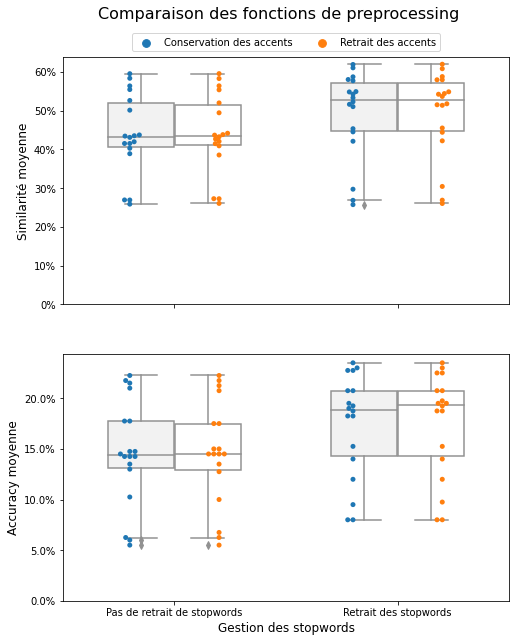

In [51]:
fig, axs = plt.subplots(nrows= 2, figsize=(8,10), sharex=True)

feats = ['mean_test_similarity', 'mean_test_accuracy']

parms = {'data': result_df.loc[result_df['run'] == 1],
         'x': 'stop_words',
         'hue': 'strip_accents',
        }

for i, feature in enumerate(feats):
    swarm = sns.swarmplot(**parms,     
                          y=feature,
                          dodge=True,
        #                   color='blue',
                          ax=axs[i],
                         )

    sns.boxplot(**parms,
                y=feature,
                ax=axs[i],
                color='white',
                width=.6,
                )

    axs[i].set_ylim(0,)
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
    axs[i].get_legend().remove()
    axs[i].set_xlabel('')

axs[1].set_xlabel('Gestion des stopwords', fontsize=12)
axs[0].set_ylabel('Similarité moyenne', fontsize=12)
axs[1].set_ylabel('Accuracy moyenne', fontsize=12)
axs[1].set_xticklabels(['Pas de retrait de stopwords', 'Retrait des stopwords'])

fig.legend(handles=axs[0].get_legend_handles_labels()[0][2:],
           labels=['Conservation des accents', 'Retrait des accents'],
           loc='center',
           ncol=2,
           bbox_to_anchor=(0, 1, 1, 0.12),
           bbox_transform=axs[0].transAxes,
          )

fig.suptitle('Comparaison des fonctions de preprocessing', fontsize=16, y=.95)

fig.savefig(Path('..') / 'img' / 'tuning_prepro.png', bbox_inches='tight')

#### Sélection de la fonction de split

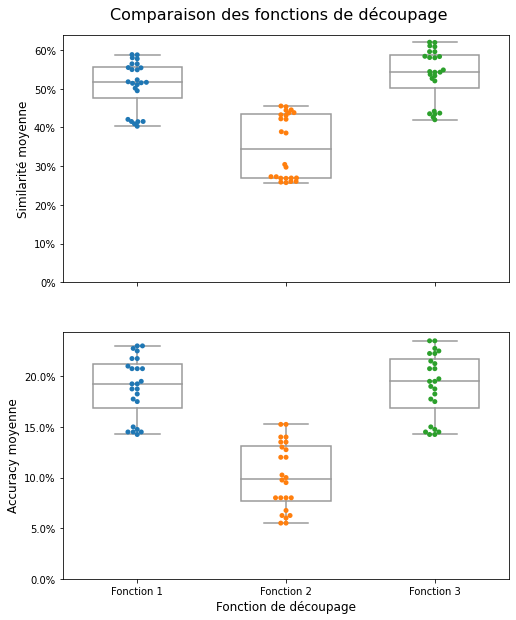

In [52]:
fig, axs = plt.subplots(nrows= 2, figsize=(8,10), sharex=True)

feats = ['mean_test_similarity', 'mean_test_accuracy']

parms = {'data': result_df.loc[result_df['run'] == 1],
         'x': 'split_func',
         'hue': None,
        }

for i, feature in enumerate(feats):
    swarm = sns.swarmplot(**parms,     
                          y=feature,
                          dodge=True,
        #                   color='blue',
                          ax=axs[i],
                         )

    sns.boxplot(**parms,
                y=feature,
                ax=axs[i],
                color='white',
                width=.6,
                )

    axs[i].set_ylim(0,)
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
#     axs[i].get_legend().remove()
    axs[i].set_xlabel('')

axs[1].set_xlabel('Fonction de découpage', fontsize=12)
axs[0].set_ylabel('Similarité moyenne', fontsize=12)
axs[1].set_ylabel('Accuracy moyenne', fontsize=12)
axs[1].set_xticklabels(['Fonction 1', 'Fonction 2', 'Fonction 3'])

# fig.legend(handles=axs[0].get_legend_handles_labels()[0][2:],
#            labels=['Conservation des accents', 'Retrait des accents'],
#            loc='center',
#            ncol=2,
#            bbox_to_anchor=(0, 1, 1, 0.12),
#            bbox_transform=axs[0].transAxes,
#           )

fig.suptitle('Comparaison des fonctions de découpage', fontsize=16, y=.92)

fig.savefig(Path('..') / 'img' / 'tuning_split.png', bbox_inches='tight')

#### Comparatif des similarités

In [53]:
result_df['simil_kind'] = result_df['similarity'] + result_df['source_norm'] + result_df['projected_norm']

In [54]:
result_df['embedding_method'].unique()

array(['not_applicable', 'no_embedding', 'Word2Vec', 'tSVD'], dtype=object)

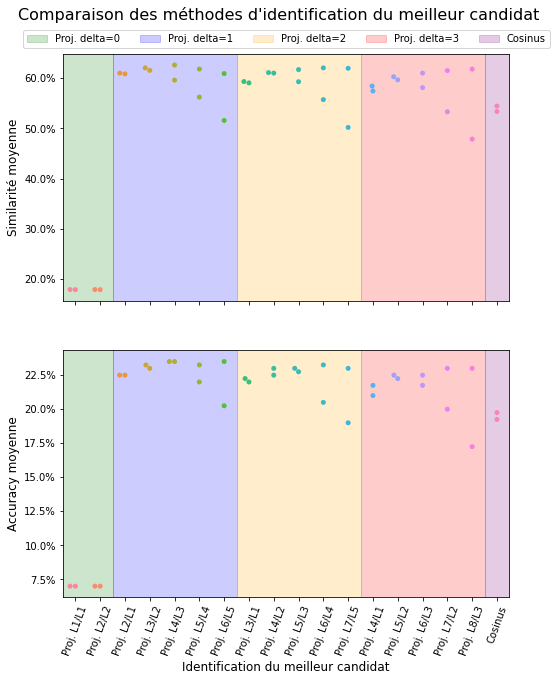

In [90]:
fig, axs = plt.subplots(nrows= 2, figsize=(8,10), sharex=True)

feats = ['mean_test_similarity', 'mean_test_accuracy']

parms = {'data': result_df.loc[(result_df['run'] == 2) & 
                               (result_df['strip_accents'] == 'accent_removal') &
                               (result_df['stop_words'] == 'stop_word_list') &
                               (result_df['scoring'].isin({'default', 'not_applicable'})) &
                               (result_df['embedding_method'].isin({'no_embedding', 'not_applicable'}))],
         'x': 'simil_kind',
         'hue': None,
        }

patch_list = [
              mpatch.Rectangle((-1, 0), 2.5, 1, color='green', alpha=.2, edgecolor=None),
              mpatch.Rectangle((1.5, 0), 5, 1, color='blue', alpha=.2, edgecolor=None),
              mpatch.Rectangle((6.5, 0), 5, 1, color='orange', alpha=.2, edgecolor=None),
              mpatch.Rectangle((11.5, 0), 5, 1, color='red', alpha=.2, edgecolor=None),    
              mpatch.Rectangle((16.5, 0), 2, 1, color='purple', alpha=.2, edgecolor=None),    
              mpatch.Rectangle((-1, 0), 2.5, 1, color='green', alpha=.2, edgecolor=None),
              mpatch.Rectangle((1.5, 0), 5, 1, color='blue', alpha=.2, edgecolor=None),
              mpatch.Rectangle((6.5, 0), 5, 1, color='orange', alpha=.2, edgecolor=None),
              mpatch.Rectangle((11.5, 0), 5, 1, color='red', alpha=.2, edgecolor=None),    
              mpatch.Rectangle((16.5, 0), 2, 1, color='purple', alpha=.2, edgecolor=None),    
             ]

for i, feature in enumerate(feats):
    swarm = sns.swarmplot(**parms,     
                          y=feature,
                          dodge=True,
        #                   color='blue',
                          ax=axs[i],
                         )

    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
    axs[i].set_xlabel('')
    for j in range(len(patch_list) // 2):
        axs[i].add_patch(patch_list[i * len(patch_list) // 2 + j])

axs[1].set_xlabel('Identification du meilleur candidat', fontsize=12)
axs[0].set_ylabel('Similarité moyenne', fontsize=12)
axs[1].set_ylabel('Accuracy moyenne', fontsize=12)
labels = ['Proj. L1/L1',
          'Proj. L2/L2',
          'Proj. L2/L1',
          'Proj. L3/L2',
          'Proj. L4/L3',
          'Proj. L5/L4',
          'Proj. L6/L5',
          'Proj. L3/L1',
          'Proj. L4/L2',
          'Proj. L5/L3',
          'Proj. L6/L4',
          'Proj. L7/L5',
          'Proj. L4/L1',
          'Proj. L5/L2',
          'Proj. L6/L3',
          'Proj. L7/L2',
          'Proj. L8/L3', 
          'Cosinus']
plt.setp( axs[1].xaxis.get_majorticklabels(), rotation=70 )
axs[1].set_xticklabels(labels)
fig.legend(handles=patch_list[len(patch_list) // 2:],
           labels=['Proj. delta=0', 'Proj. delta=1', 'Proj. delta=2', 'Proj. delta=3', 'Cosinus'],
           loc='center',
           ncol=5,
           bbox_to_anchor=(0, 1, 1, 0.12),
           bbox_transform=axs[0].transAxes,
          )

fig.suptitle("Comparaison des méthodes d'identification du meilleur candidat", fontsize=16, y=.945)

fig.savefig(Path('..') / 'img' / 'tuning_similarite.png', bbox_inches='tight')